In [2]:
import os
import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import sys 
import torch
import torch.nn as nn
from torchvision import models, transforms
import PIL
from skimage.transform import resize
import torch.nn.functional as F
import matplotlib.cm as cm
import shutil


p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid
from scipy.optimize import curve_fit

import notebooks_utils


In [3]:
# put your parameters here

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/" # to result sketches of the semantic simplification (first row) 
path_to_files = "/home/vinker/dev/input_images/background_sketching/" # to input images

# Util functions

In [11]:
def ratios_to_str(ratios):
    ratios_str = ""
    for r_ in ratios:
        r_str = f"{r_:.3f}"
        ratios_str += f"{float(r_str)},"
    ratios_str = ratios_str[:-1]
    return ratios_str

def get_clip_loss(path, layer, object_or_background):
    path_config = f"{path}/config.npy"
    config = np.load(path_config, allow_pickle=True)[()]
    loss_clip = np.array(config[f"loss_eval"])
    best_iter = np.argsort(loss_clip)[0]
    loss_clip_layer = np.array(config[f"clip_vit_l{layer}_original_eval"])
    if object_or_background == "object":
        loss_clip_layer4 = np.array(config[f"clip_vit_l4_original_eval"])
        loss_clip_layer = 1*loss_clip_layer4 + loss_clip_layer
    return best_iter, loss_clip_layer

def func(x, a, c, d):
    return a*np.exp(c*x)

def func_inv(y,a,c,d):
    return np.log(y / a) * (1 / c)

def get_func(ratios_rel, start_x, start_ys):
    target_ys = ratios_rel[start_ys:]
    x = np.linspace(start_x, start_x + len(target_ys) - 1, len(target_ys))
    # calculate polynomial
    popt, pcov = curve_fit(func, x, target_ys, maxfev=3000)
    return popt

def get_ratios_srt2(path_to_initial_sketches, folder_name_l, layer, object_or_background, step_size_l, num_ratios=8):
    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{folder_name_l}")
    seed = notebooks_utils.get_seed(svg_filename)
    path_li = f"{path_to_initial_sketches}/{folder_name_l}/{folder_name_l}_seed{seed}"
    best_iter, loss_clip_layer = get_clip_loss(path_li, layer, object_or_background)
    best_lclip_layer = loss_clip_layer[best_iter]
    r_1_k = 1 / best_lclip_layer
    
    # get the next ratios by jumping by 2
    r_j_k = r_1_k
    ratios_k = [r_1_k]
    for j in range(4):
        r_j_k = r_j_k / 2
        ratios_k.append(r_j_k)
    start_ys, start_x, end_x_addition = 0, 0, 0
    popt = get_func(ratios_k, start_x=0, start_ys=0) # fit the function to ratios_k
    x_1_k = func_inv([r_1_k], *popt)

    step_size = step_size_l
    num_steps = num_ratios - start_x + end_x_addition
    start_ = x_1_k[0]
    end = num_steps * step_size
    # sample the function from the initial scaled r_1 with the corresponding step size
    new_xs_layer_l = np.linspace(start_, end - step_size + start_, num_steps) 
    # print("new_xs_layer_l", new_xs_layer_l)
    ratios_li = func(new_xs_layer_l, *popt)
    ratios_str = ratios_to_str(ratios_li)
    xs_layer_l_str = ratios_to_str(new_xs_layer_l)
    # print(f"layer {layer} r_1_k {r_1_k} \n new {ratios_str} \n x {xs_layer_l_str}\n")
    return ratios_str

def init_dict(layers):
    d = {}
    for l in layers:
        d[l] = {}
    return d

def draw_graph(ys, layer, i, colors, ylabel, xlabel, title, label=None, x_vals=None):
    if x_vals is None:
        x_vals = range(len(ys))
        plt.plot(x_vals, ys, c=np.array([colors[i]]))
    if label is None:
        label = f"layer {layer}"
        
    plt.scatter(x_vals, ys, label=label, s=20, c=np.array([colors[i]]))
    for k in range(len(ys)):
        if x_vals is None:
            plt.annotate("{:.2f}".format(ys[k]), (x_vals[k], ys[k]), fontsize=10)
        else:
            plt.annotate("{:.0f}".format(k), (x_vals[k], ys[k]), fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.xlabel(xlabel, fontsize=10)
    plt.title(title)
    plt.legend()

def get_semantic_image(res_filename, resize_obj, params):
    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{res_filename}")
    path_svg = f"{path_to_initial_sketches}/{res_filename}/{svg_filename}"
    im = notebooks_utils.read_svg(path_svg, resize_obj=resize_obj, params=params, multiply=1)
    return im

def get_res_filename(im_name_, object_or_background, layer, resize_obj):
    im_name = im_name_
    if object_or_background == "background":
        im_name = f"{im_name_}_mask"
    res_filename = f"{object_or_background}_l{layer}_64s_{im_name}"
    if resize_obj:
        res_filename += f"_resize{resize_obj}"
    path_res = f"{path_to_initial_sketches}/{res_filename}"
    if not os.path.isdir(path_res):
        res_filename = f"{res_filename}_resize{resize_obj}"
    return res_filename

def get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, ablation_name_pref=""):
    test_name_pref = f"l{layer}_64s_{im_name}_{min_div}{ablation_name_pref}"
    if resize_obj:
        test_name_pref += f"_resize{resize_obj}"
    res_filename = f"ratio{r}_{test_name_pref}"
    path_res = f"{path_to_res}/{res_filename}"
    if not os.path.isdir(path_res):
        res_filename = f"{res_filename}_resize{resize_obj}"
    path_res = f"{path_to_res}/{res_filename}"
    if not os.path.isdir(path_res):
        test_name_pref = f"l{layer}_64s_{im_name}_{ablation_name_pref}"
        res_filename = f"ratio{r}_{test_name_pref}"
    return res_filename  

  
def get_sketches(layer, ratios, im_name, min_div, resize_obj, path_to_res, params, ablation_name_pref=""):
    images = []
    for j, r in enumerate(ratios):
        res_filename = get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, ablation_name_pref=ablation_name_pref)
        best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res}/{res_filename}")
        path_best_im = f"{path_to_res}/{res_filename}/{best_svg_filename}"
        im = notebooks_utils.read_svg(path_best_im, resize_obj=resize_obj, params=params)
        images.append(im)
    return images

def draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, divs, step=1, resize_obj=0, output_path="", save_results=0):
    
    for im_name_ in images:
        target_path = f"{path_to_files}/{im_name_}.jpg"
        target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=resize_obj, return_params=resize_obj)
        im_name = im_name_
        if object_or_background == "background":
            im_name = f"{im_name_}_mask"
            
        figa = plt.figure(figsize=(len(layers)*2, 8*2))
        # figa = plt.figure(figsize=(7,10))
        for i, layer in enumerate(layers):
            res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
            im = get_semantic_image(res_filename, resize_obj, params)
            
            min_div = divs[i]
            ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)
            ratios = [float(item) for item in ratios_str.split(',')]
            k = 0
            images = get_sketches(layer, ratios, im_name, min_div, resize_obj, path_to_res, params)
            for j in range(len(images)):
                if save_results:
                    filename = f"l{layer}{im_name}_abs{k}"
                    im_ = images[j]
                    im_ = ((im_ / im_.max()) * 255).astype(np.uint8)
                    imageio.imsave(f"{output_path}/{filename}.png", im_)
                if j % step == 0:
                    plt.subplot(len(images) + 1, len(layers), (k + 1) * len(layers) + i + 1)
                    plt.imshow(images[j])
                    plt.axis("off")
                    k += 1
                
        plt.tight_layout()
        # plt.savefig(f"matrix_07_09/{im_name}.png")
        plt.show()
        plt.close()
        

def draw_images(images, step):
    # figa = plt.figure(figsize=(2, len(images)*2))
    figa = plt.figure(figsize=(len(images)*2, 2))
    k = 0
    for j in range(len(images)):
        if j % step == 0:
            # plt.subplot(len(images) + 1, 1, (k + 1) + 1)
            plt.subplot(1,len(images) + 1, (k + 1) + 1)
            plt.imshow(images[j])
            plt.axis("off")
            k += 1
    plt.tight_layout()
    # plt.savefig(f"matrix_07_09/{im_name}.png")
    plt.show()
    plt.close()

    
def draw_fidelity_axis(object_or_background, images, layers, path_to_res, divs, step=1, resize_obj=0, output_path="", save_results=0):
    for im_name_ in images:
        target_path = f"{path_to_files}/{im_name_}.jpg"
        target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=resize_obj, return_params=resize_obj)
        im_name = im_name_
        if object_or_background == "background":
            im_name = f"{im_name_}_mask"
            
        figa = plt.figure(figsize=(len(layers)*2, 8*2))
        # figa = plt.figure(figsize=(7,10))
        for i, layer in enumerate(layers):
            res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
            print(res_filename)
            im = get_semantic_image(res_filename, resize_obj, params)
            plt.subplot(1, len(layers), i + 1)
            plt.imshow(im)
            plt.axis("off")
            if save_results:
                filename = f"{im_name}_{i}"
                im_ = ((im / im.max()) * 255).astype(np.uint8)
                imageio.imsave(f"{output_path}/{filename}.png", im_)
        plt.tight_layout()
        # plt.savefig(f"matrix_07_09/{im_name}.png")
        plt.show()
        plt.close()


# Drae background and foreground seperately

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device
setting device


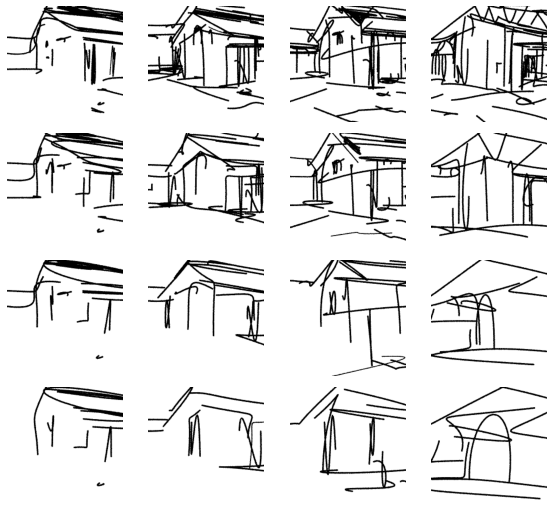

In [12]:
images=["semi-complex"]
# path_to_res = "/home/vinker/dev/background_project/experiements/ratio_14_10/" # simplified sketches
# path_to_res = "/home/vinker/dev/background_project/experiements/ratio_intro_figure/" # simplified sketches
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/" # simplified sketches

path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/" # semantic axis
save_results=1
output_path = "/home/vinker/dev/background_project/paper_results/matrices/semi-complex-back"

object_or_background, resize_obj = "background", 0
layers = [2,7,8,11]
divs = [0.35,0.45,0.5,0.9]
# layers = [11]
# divs = [0.9]
draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, divs, step=2, output_path=output_path, save_results=save_results)
# draw_fidelity_axis(object_or_background, images, layers, path_to_res, divs, step=1, resize_obj=0, output_path=output_path, save_results=save_results)
# object_or_background, resize_obj = "object", 1
# layers = [2,7,8,11]
# divs = [0.45,0.4,0.5,0.9]
# draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, divs, step=2, resize_obj=resize_obj)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


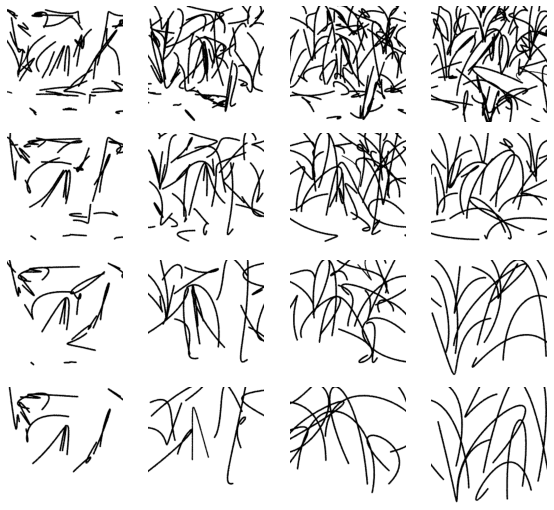

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


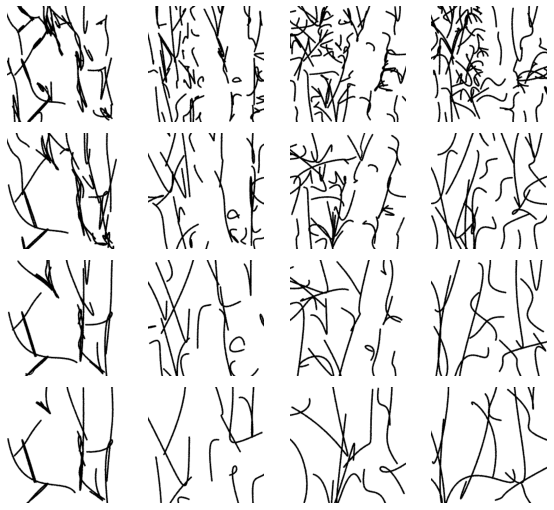

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


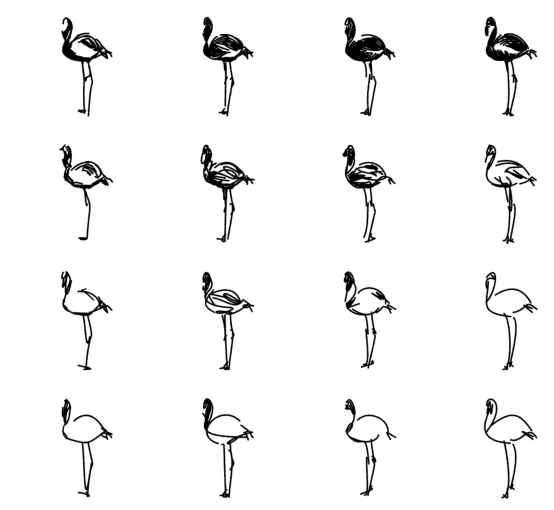

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


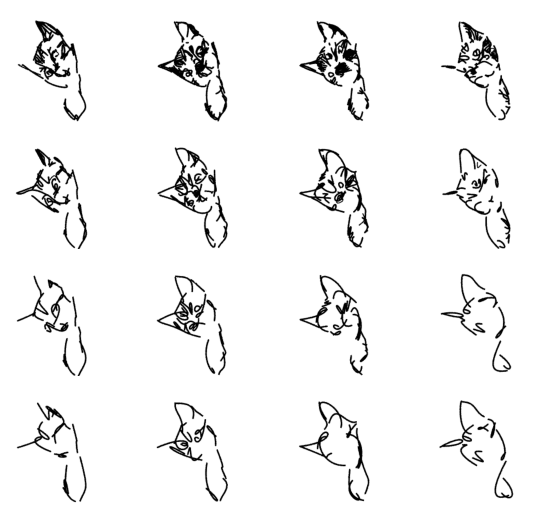

In [36]:
images=["flamingo_a", "cat_b"]
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_14_10/" # simplified sketches
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/" # semantic axis
    
object_or_background, resize_obj = "background", 0
layers = [2,7,8,11]
divs = [0.35,0.45,0.5,0.9]
draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, divs, step=2)

object_or_background, resize_obj = "object", 1
layers = [2,7,8,11]
divs = [0.45,0.4,0.5,0.9]
draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, divs, step=2, resize_obj=resize_obj)

# Draw the combined matrix

## Utils

In [45]:
def get_matrix(im_name, layers, object_or_background, divs, path_to_res, path_to_initial_sketches, resize_obj=0, params=None, background_opacity=1, save_results=0):
    matrix = []
    op = 1
    if object_or_background == "background":
        im_name = f"{im_name}_mask"
        op = background_opacity
        
    for i, layer in enumerate(layers):
        sketches_col = []
        res_filename = f"{object_or_background}_l{layer}_64s_{im_name}"
        if resize_obj:
            res_filename += f"_resize{resize_obj}"
        path_res = f"{path_to_initial_sketches}/{res_filename}"
        if not os.path.isdir(path_res):
            res_filename = f"{res_filename}_resize{resize_obj}"
        svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{res_filename}")
        path_svg = f"{path_to_initial_sketches}/{res_filename}/{svg_filename}"
        sketch = notebooks_utils.read_svg(path_svg, resize_obj=resize_obj, params=params, opacity=op, multiply=save_results)
        
        min_div = divs[i]
        ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)
        ratios = [float(item) for item in ratios_str.split(',')]

        ratios_res = []
        num_strokes_res = []
        
        k = 0
        for j, r in enumerate(ratios):
            test_name_pref = f"l{layer}_64s_{im_name}_{min_div}"
            if resize_obj:
                test_name_pref += f"_resize{resize_obj}"
            path_res = f"{path_to_res}/{res_filename}"
            if not os.path.isdir(path_res):
                res_filename = f"{res_filename}_resize{resize_obj}"
            res_filename = f"ratio{r}_{test_name_pref}"
            best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res}/{res_filename}")
            path_best_im = f"{path_to_res}/{res_filename}/{best_svg_filename}"
            sketch = notebooks_utils.read_svg(path_best_im, resize_obj=resize_obj, params=params, opacity=op, multiply=save_results)
            sketches_col.append(sketch)
        matrix.append(sketches_col)

    matrix = np.array(matrix)
    return matrix


def draw_matrix(matrix_back, matrix_obj, mask_np, step=1, save_results=0, output_path=""):
    mean_over_rows = matrix_back.mean(axis=0)
    
    if save_results:
        mask_np = resize(mask_np, (mask_np.shape[0] * 2, mask_np.shape[1] * 2), order=0)

    figa = plt.figure(figsize=(int(matrix_back.shape[0] * 2), int(matrix_back.shape[1] * 2)))
    for layer_index in range(matrix_back.shape[0]):
        k = 0
        for ratio_index in range(matrix_back.shape[1]):
            if ratio_index % step == 0:
                mean_back = mean_over_rows[ratio_index]
                back_cur = matrix_back[layer_index, ratio_index]
                back_cur_op, mean_back_op = 1 - back_cur, 1 - mean_back 
                # back_blend = 0.5 * back_cur_op + 0.5 * mean_back_op
                back_blend = 1 * back_cur_op
                back_blend = 1 - back_blend
                back_blend[mask_np == 1] = 1

                obj_cur = matrix_obj[layer_index, ratio_index]
                obj_cur_op = (1 - obj_cur)
                back_blend_op = (1 - back_blend) #* 0.7
                back_blend_op[obj_cur_op > 0.0] = 1 * obj_cur_op[obj_cur_op > 0.0]
                # back_blend = 1 - back_blend_op
                im_blend = 1 - back_blend_op
                plt.subplot(matrix_back.shape[1], matrix_back.shape[0], (k) * matrix_back.shape[0] + layer_index + 1)
                plt.imshow(im_blend)
                plt.axis("off")
                k += 1
                
                if save_results:
                    r_i = int(ratio_index / step)
                    filename = f"{im_name}_row{r_i}col{layer_index}_black"
                    im_blend_ = ((im_blend / im_blend.max()) * 255).astype(np.uint8)
                    imageio.imsave(f"{output_path}/{filename}.png", im_blend_)
                    
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_input_im_and_mask(target, mask_np):
    plt.subplot(1,2,1)
    plt.imshow(target[0].permute(1,2,0).cpu())
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(mask_np)
    plt.axis("off")
    plt.show()
    plt.close()

## draw the matrix

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


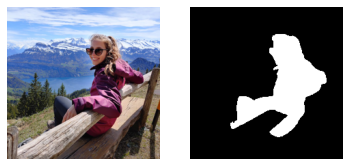

FileNotFoundError: [Errno 2] No such file or directory: '/home/vinker/dev/background_project/experiements/ratio_14_10//ratio44.077_l2_64s_yael_mask_0.35'

In [65]:
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/" # semantic axis
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_14_10/" # simplification axis

save_results=0
output_path = "/home/vinker/dev/background_project/paper_results/matrices"

images = ["yael"]
layers = [2,7,8,11]

for im_name in images:
    target_path = f"{path_to_files}/{im_name}.jpg"
    target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=1, return_params=1)
    mask_np = original_mask[0].permute(1,2,0).cpu().numpy()
    plot_input_im_and_mask(target, mask_np)
    
    divs = [0.35,0.45,0.5,0.9]
    matrix_back = get_matrix(im_name, layers, "background", divs, path_to_res, path_to_initial_sketches, resize_obj=0, params=params, background_opacity=1, save_results=save_results)
    divs = [0.35,0.4,0.5,0.9]
    matrix_obj = get_matrix(im_name, layers, "object", divs, path_to_res, path_to_initial_sketches, resize_obj=1, params=params, save_results=save_results)
    
    draw_matrix(matrix_back, matrix_obj, mask_np, step=2, save_results=save_results, output_path=output_path)
    

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


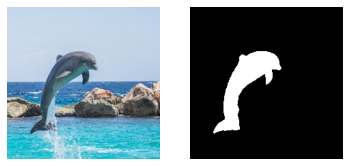

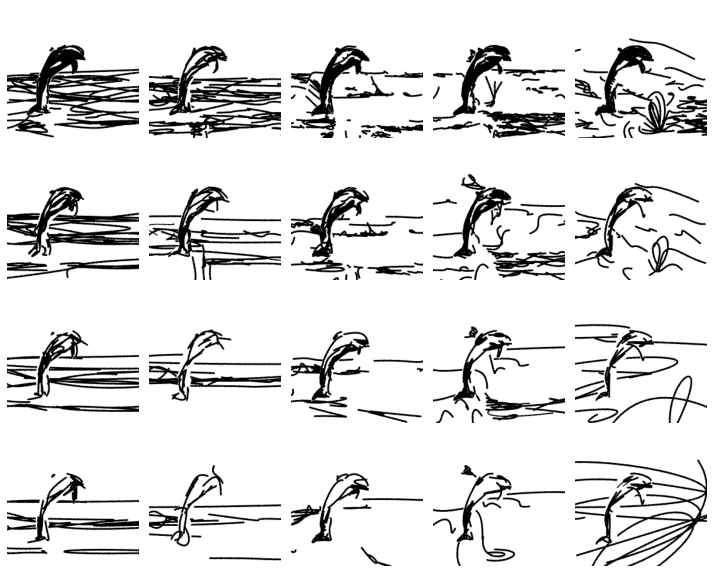

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


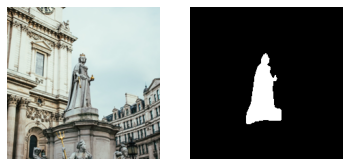

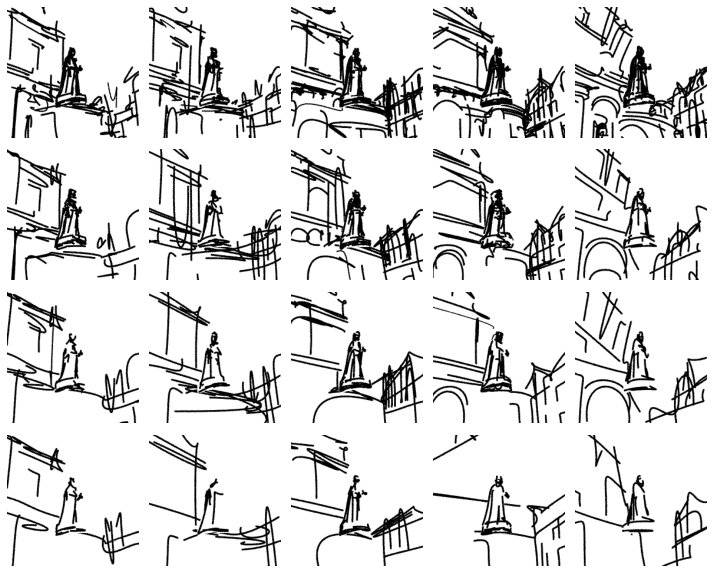

In [51]:
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/" # semantic axis
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_14_10/" # simplification axis

images = ["dolphin", "queen2"]
layers = [2,4,7,8,11]


for im_name in images:
    target_path = f"{path_to_files}/{im_name}.jpg"
    target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=resize_obj, return_params=resize_obj)
    mask_np = original_mask[0].permute(1,2,0).cpu().numpy()
    plot_input_im_and_mask(target, mask_np)
    
    divs = [0.35,0.45,0.45,0.5,0.9]
    matrix_back = get_matrix(im_name, layers, "background", divs, path_to_res, path_to_initial_sketches, resize_obj=0, params=params, background_opacity=1)
    divs = [0.45,0.4,0.4,0.5,0.9]
    matrix_obj = get_matrix(im_name, layers, "object", divs, path_to_res, path_to_initial_sketches, resize_obj=1, params=params)
    
    draw_matrix(matrix_back, matrix_obj, mask_np, step=2, save_results=save_results, output_path=output_path)
    
    

In [1]:
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/" # semantic axis
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/" # simplification axis

images = ["yael"]
layers = [2,7,8,11]

save_results=1
for im_name in images:
    target_path = f"{path_to_files}/{im_name}.jpg"
    target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=resize_obj, return_params=resize_obj)
    mask_np = original_mask[0].permute(1,2,0).cpu().numpy()
    plot_input_im_and_mask(target, mask_np)
    
    divs = [0.35,0.45,0.5,0.9]
    matrix_back = get_matrix(im_name, layers, "background", divs, path_to_res, path_to_initial_sketches, resize_obj=0, params=params, background_opacity=1, save_results=save_results)
    divs = [0.45,0.4,0.5,0.9]
    matrix_obj = get_matrix(im_name, layers, "object", divs, path_to_res, path_to_initial_sketches, resize_obj=1, params=params, save_results=save_results)
    
    draw_matrix(matrix_back, matrix_obj, mask_np, step=2, save_results=save_results, output_path=output_path)
    
    

NameError: name 'path_to_files' is not defined